In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import tarfile
from torchvision.datasets import ImageFolder

In [4]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100.0%


In [6]:
with tarfile.open('./cifar10.tgz','r:gz') as tr:
    tr.extractall(path='./data')

In [26]:
import os
data_dir = './data/cifar10'

print(os.listdir(path = data_dir + '/train'))
classes = os.listdir(path = data_dir + '/train')
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [27]:
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

train_dataset = ImageFolder(root=train_dir,transform=ToTensor())
test_dataset = ImageFolder(root=test_dir,transform=ToTensor())

Text(0.5, 1.0, 'airplane')

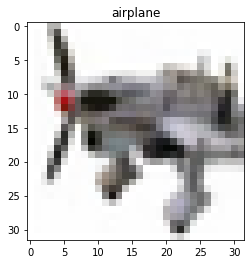

In [28]:
img,label = train_dataset[3]
plt.imshow(img.permute(1,2,0).numpy())
plt.title(classes[label])

Text(0.5, 1.0, 'airplane')

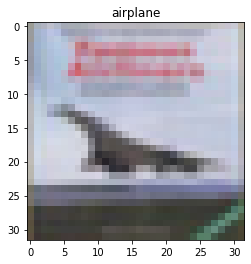

In [29]:
img,label = test_dataset[0]
plt.imshow(img.permute(1,2,0).numpy())
plt.title(classes[label])

In [30]:
# Constants

BATCH_SIZE = 64
random_seed = 42
Data_available = len(train_dataset)
training_data_size = int(0.85*Data_available)
validation_data_size = Data_available - training_data_size
print(training_data_size,validation_data_size)

torch.manual_seed(random_seed)

42500 7500


In [31]:
train_dl,val_dl = random_split(train_dataset,lengths=[training_data_size,validation_data_size])

In [32]:
train_dl = DataLoader(train_dl,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dl,batch_size=BATCH_SIZE,pin_memory=True)

In [33]:
def apply_kernel(image,kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro,co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck]*kernel)
    return output

In [34]:
sample_image = torch.tensor([
    [2,2,2,0,0,1],
    [1,1,1,1,1,1],
    [1,0,0,0,0,0],
    [2,3,5,6,7,8],
    [1,2,3,4,5,6]
],dtype=torch.float32)

sample_kernel = torch.tensor([
    [0,1,0],
    [0,1,0],
    [0,1,0]
],dtype=torch.float32)

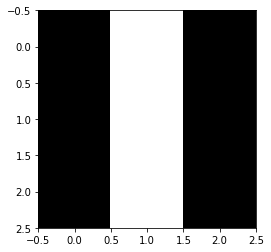

In [35]:
plt.imshow(sample_image.numpy(),cmap ='gray')
plt.imshow(sample_kernel.numpy(),cmap='gray')

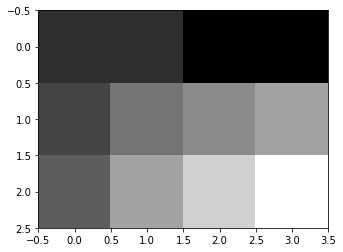

In [36]:
output = apply_kernel(sample_image,sample_kernel)
plt.imshow(output.numpy(),cmap = "gray")

In [37]:
'''dummpy_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(8,32,kernel_size=3,stride=1,padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(32*16*16,10),
    nn.LogSoftmax()
)'''


'dummpy_model = nn.Sequential(\n    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),\n    nn.ReLU(),\n    nn.Conv2d(8,32,kernel_size=3,stride=1,padding=1),\n    nn.LeakyReLU(),\n    nn.MaxPool2d(kernel_size=2,stride=2),\n    nn.Flatten(),\n    nn.Linear(32*16*16,10),\n    nn.LogSoftmax()\n)'

In [38]:
'''for img,label in train_dl:
    print('Imput image Shape :- ',img.shape)
    out = dummpy_model(img)
    print('Output Images Shape :- ',out.shape)
    print(out)
    break'''

"for img,label in train_dl:\n    print('Imput image Shape :- ',img.shape)\n    out = dummpy_model(img)\n    print('Output Images Shape :- ',out.shape)\n    print(out)\n    break"

In [39]:
def accuracy(output,label):
    _, pred = torch.max(output,dim=1)
    return torch.tensor(torch.sum(pred==label).item()/len(pred))

In [40]:
class Image_Classification_Base(nn.Module):
    
    # Performs a step of feed-forward and calculates the cross entropy loss
    def training_step(self,batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out, label)
        return loss
    
    def validation_step(self,batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out,label)
        acc = accuracy(out,label)
        return {'val_loss':loss.detach(),'val_acc':acc}

    def validation_epoch_end(self,output):
        batch_loss = [x['val_loss']for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch_no,result):
        print("Epochs [{}], Train Loss :- {:4f}, Val Loss :- {:4f}, Val Accuracy :- {:4f}"
        .format(epoch_no,result['train_loss'],result['val_loss'],result['val_acc']))
    

In [41]:
class CIFR10_CNN_Model(Image_Classification_Base):
    def __init__(self):
        super().__init__()
        self.Model = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,10),
            nn.LogSoftmax()
        )

    def forward(self,xb):
        return self.Model(xb)

In [42]:
model = CIFR10_CNN_Model()
model

CIFR10_CNN_Model(
  (Model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

In [43]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl) 


In [44]:
device = get_default_device()
device

device(type='cuda')

In [45]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [46]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(CIFR10_CNN_Model(), device)

In [48]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [49]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epochs [0], Train Loss :- 1.678362, Val Loss :- 1.280540, Val Accuracy :- 0.523791
Epochs [1], Train Loss :- 1.107630, Val Loss :- 1.067452, Val Accuracy :- 0.623852
Epochs [2], Train Loss :- 0.846654, Val Loss :- 0.830544, Val Accuracy :- 0.710761
Epochs [3], Train Loss :- 0.655387, Val Loss :- 0.732573, Val Accuracy :- 0.752737
Epochs [4], Train Loss :- 0.513867, Val Loss :- 0.723470, Val Accuracy :- 0.764698
Epochs [5], Train Loss :- 0.377518, Val Loss :- 0.806924, Val Accuracy :- 0.763286
Epochs [6], Train Loss :- 0.278269, Val Loss :- 0.804113, Val Accuracy :- 0.773438
Epochs [7], Train Loss :- 0.197424, Val Loss :- 0.909001, Val Accuracy :- 0.767082
Epochs [8], Train Loss :- 0.150672, Val Loss :- 1.031591, Val Accuracy :- 0.768450
Epochs [9], Train Loss :- 0.134359, Val Loss :- 1.127225, Val Accuracy :- 0.764036


In [50]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

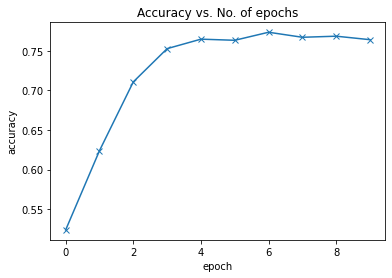

In [51]:
plot_accuracies(history)

In [52]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

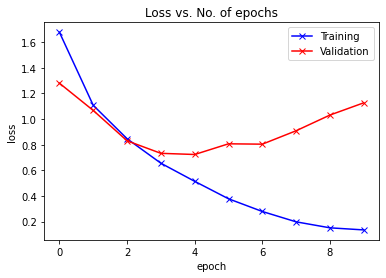

In [53]:
plot_losses(history)

In [54]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [56]:
model2 = to_device(CIFR10_CNN_Model(), device)

In [57]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [58]:
test_dl = DeviceDataLoader(DataLoader(test_dataset,BATCH_SIZE),device)
evaluate(model2, test_dl)

C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_loss': 1.1069443225860596, 'val_acc': 0.759255588054657}